<a href="https://colab.research.google.com/github/ohadtay/StrideSight/blob/main/StrideSight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

## Preparation

In [1]:
# prepare environment

!pip install -q mediapipe
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
!pip install azure-kusto-data
!pip install azure-kusto-ingest
!pip install azure-mgmt-kusto

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
# Imports

import io
from google.colab import files
import io
import cv2
import numpy as np
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow
import mediapipe as mp
import pandas as pd
import time

from azure.kusto.data.data_format import DataFormat
from azure.kusto.ingest import (
    BlobDescriptor,
    FileDescriptor,
    IngestionProperties,
    IngestionStatus,
    KustoStreamingIngestClient,
    ManagedStreamingIngestClient,
    QueuedIngestClient,
    StreamDescriptor,
)

from azure.kusto.ingest import StreamDescriptor
from azure.identity import DeviceCodeCredential
from azure.kusto.data import KustoConnectionStringBuilder
from azure.mgmt.kusto import KustoManagementClient
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.identity import DefaultAzureCredential


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

# !wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg


# img = cv2.imread("image.jpg")
# cv2_imshow(img)

!pip install azure-identity azure-storage-blob
!pip install --upgrade azure-storage-blob

!curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
!az login



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 13.4 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia

## Upload file

In [2]:
from google.colab import files
import os

def GetFileFromUser():

  uploaded = files.upload()

  # Check if any file was uploaded
  if uploaded:
    for filename in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=filename, length=len(uploaded[filename])))

      # Save the uploaded video to a file
      with open(filename, 'wb') as f:
        f.write(uploaded[filename])

      print(f"Saved video file as: {filename}")

      # Now you can proceed with processing the video using 'filename'
      # ... your video processing code here ...
      return filename
  else:
    print("No video file uploaded.")


filename = GetFileFromUser()

import os

def GetConvertedFileName(filename):
  base_dir, old_filename = os.path.split(filename)
  new_filename = os.path.splitext(old_filename)[0] + "_converted" + os.path.splitext(old_filename)[1]
  new_path = os.path.join(base_dir, new_filename)
  return new_path

converted_file_name = GetConvertedFileName(filename)

print(f"converting video..")

!ffmpeg -i "$filename" -vcodec libx264 "$converted_file_name" -hide_banner -loglevel error

print(f"converted file is at {converted_file_name}")

#upload to blob storage

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import random
import string
import re

# Replace with your actual container name and blob name
container_name = "convertedvideos"

def GetBlobName(filename):
  base_dir, old_filename = os.path.split(filename)
  # Generate a random string prefix
  random_prefix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=3))
  # Replace invalid characters with underscores
  valid_filename = re.sub(r'[^\w\-]', '_', old_filename)
  # Remove leading and trailing hyphens
  valid_filename = valid_filename.strip('-')
  # Remove consecutive hyphens
  valid_filename = re.sub(r'-+', '-', valid_filename)
  # Add prefix to the filename
  return f"{random_prefix}_{valid_filename}"

blob_name = GetBlobName(converted_file_name)

print(blob_name)
local_file_path = converted_file_name


# Create a BlobServiceClient object using the DefaultAzureCredential
blob_service_client = BlobServiceClient(account_url="https://eddiebkheethackathonsa.blob.core.windows.net", credential=DefaultAzureCredential())

# Create a container client
container_client = blob_service_client.get_container_client(container_name)

# Create container if not exists
if not container_client.exists():
    container_client.create_container()

# Create a blob client
blob_client = container_client.get_blob_client(blob_name)

# Upload the file
with open(local_file_path, "rb") as data:
    blob_client.upload_blob(data)

# Get and print the blob URL
blob_url = blob_client.url

print(f"successfully uploaded file to blob storage, url: {blob_url}")



Saving treadmile.mp4 to treadmile.mp4
User uploaded file "treadmile.mp4" with length 1554359 bytes
Saved video file as: treadmile.mp4
converting video..
converted file is at treadmile_converted.mp4
r6v_treadmile_converted_mp4
successfully uploaded file to blob storage, url: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/r6v_treadmile_converted_mp4


In [4]:
location = input("Enter the location (e.g., australiaeast): ")
resource_group_name = input("Enter the resource group name (e.g., ohadRGtest): ")
cluster_name = input("Enter the cluster name (e.g., ohadtaylereaau): ")
subscription_id = input("Enter the subscription ID (e.g., 58359f48-f3fe-4fd2-b007-4e3dede54d09): ")
isDev = bool(input("Is it development environemnt (answer true or false)?"))

credentials = DefaultAzureCredential()

dev_cred = ".dev" if isDev else ""

cluster = f"https://{cluster_name}.{location}{dev_cred}.kusto.windows.net/"

Enter the location (e.g., australiaeast): australiaeast
Enter the resource group name (e.g., ohadRGtest): ohadRGtest
Enter the cluster name (e.g., ohadtaylereaau): ohadtaylereaau
Enter the subscription ID (e.g., 58359f48-f3fe-4fd2-b007-4e3dede54d09): 58359f48-f3fe-4fd2-b007-4e3dede54d09
Is it development environemnt (answer true or false)?true


In [5]:
# Create or update the database
database_name = 'StrideSights'

parameters = {
    'location': location,
    'soft_delete_period': 'P365D',
    'hot_cache_period': 'P31D',
    'kind': 'ReadWrite'
}

kusto_mgmt_client = KustoManagementClient(credentials, subscription_id)
database = kusto_mgmt_client.databases.begin_create_or_update(resource_group_name, cluster_name, database_name, parameters)

print(f'Database created successfully.')

kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(cluster)
client = KustoClient(kcsb)

Database created successfully.


In [ ]:
import json

# Creating table

additional_fields = [f"X{i}: real,\n Y{i}: real" for i in range(0, 33)]
additional_fields_str = ",\n    ".join(additional_fields)

create_table_command = f"""
.create-merge table StrideCoordinateTable (
    {additional_fields_str},
    frame: int,
    bloburl: string
)
"""

respond = client.execute_mgmt(database_name, create_table_command)

In [ ]:
#Creating ingest client

# Database and Table Names
database_name = "StrideSights"
table_name = "StrideCoordinateTable"

ingestion_props = IngestionProperties(
    database=database_name,
    table=table_name,
    data_format=DataFormat.CSV
)

dataManagement = f"https://ingest-{cluster_name}.{location}{dev_cred}.kusto.windows.net/"
kcsbDM = KustoConnectionStringBuilder.with_az_cli_authentication(dataManagement)

# The authentication method will be taken from the chosen KustoConnectionStringBuilder.
ingest_client = QueuedIngestClient(kcsbDM)


## Analyze video

In [7]:

# Visualization function (same as before)
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def AnalyzeVideo(video_path):
  framewidth = 1
  results = []
  # Video analysis with frame skipping for per-second analysis
  try:
      cap = cv2.VideoCapture(video_path)
      fps = cap.get(cv2.CAP_PROP_FPS)
      frame_skip = 4 # Skip frames to process approximately every second
      frame_count = 0
      columns = [f'{coord}{i}' for i in range(33) for coord in ['X', 'Y']] + ['frame'] + ['bloburl']

      if not cap.isOpened():
          print("Error opening video file.")
      else:
          print("Analyzing the video file")
          while(cap.isOpened()):
              ret, frame = cap.read()
              if ret == True:
                  if frame_count % frame_skip == 0:  # Process every 'frame_skip' frames

                      frame_shape = frame.shape
                      image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                      detection_result = detector.detect(image)
                      if (framewidth == 1):
                        framewidth = frame_shape[1]

                      # todo: maybe support another person (??)
                      data = []
                      for l in detection_result.pose_landmarks[0]:
                        data.extend((l.x * frame_shape[1], l.y*frame_shape[0]))
                      data.extend((int(frame_count), blob_url))

                      results.append(data)


                  frame_count += 1
                  if cv2.waitKey(1) & 0xFF == ord('q'):
                      break
              else:
                  break

      cap.release()
      cv2.destroyAllWindows()
      print("Done analyzing")
      return framewidth
  except Exception as e:
      print(f"An error occurred: {e}")

  # Create a DataFrame and ingest data
  df = pd.DataFrame(results, columns=columns)
  csv_data = df.to_csv(index=False,header=False)
  stream = io.StringIO(csv_data)
  stream_descriptor = StreamDescriptor(stream)
  ingestion_result = ingest_client.ingest_from_stream(stream_descriptor, ingestion_properties=ingestion_props) #consider ingesting on all data instead by row
  print(f'Data ingestion started with result {ingestion_result}')
  return results

framewidth = AnalyzeVideo(converted_file_name)

Analyzing the video file
Done analyzing


## Visualize Result

Recently uploaded blob url: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/r6v_treadmile_converted_mp4
Choose frame to visualize: 68
Blob downloaded successfully to ./downloads/r6v_treadmile_converted_mp4
getting frame 68
(1280, 720, 3)
PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.4468725323677063, y=0.36230313777923584, z=0.019895553588867188, visibility=0.9999632835388184, presence=0.9999897480010986), NormalizedLandmark(x=0.4541771113872528, y=0.3531343936920166, z=-0.016637401655316353, visibility=0.9999474287033081, presence=0.9999855756759644), NormalizedLandmark(x=0.4579429626464844, y=0.3529079556465149, z=-0.016987673938274384, visibility=0.9999570846557617, presence=0.9999898672103882), NormalizedLandmark(x=0.46134692430496216, y=0.35277196764945984, z=-0.01703103631734848, visibility=0.9999666213989258, presence=0.9999895095825195), NormalizedLandmark(x=0.45356959104537964, y=0.35280507802963257, z=0.04302232712507248, visibility=0.99994

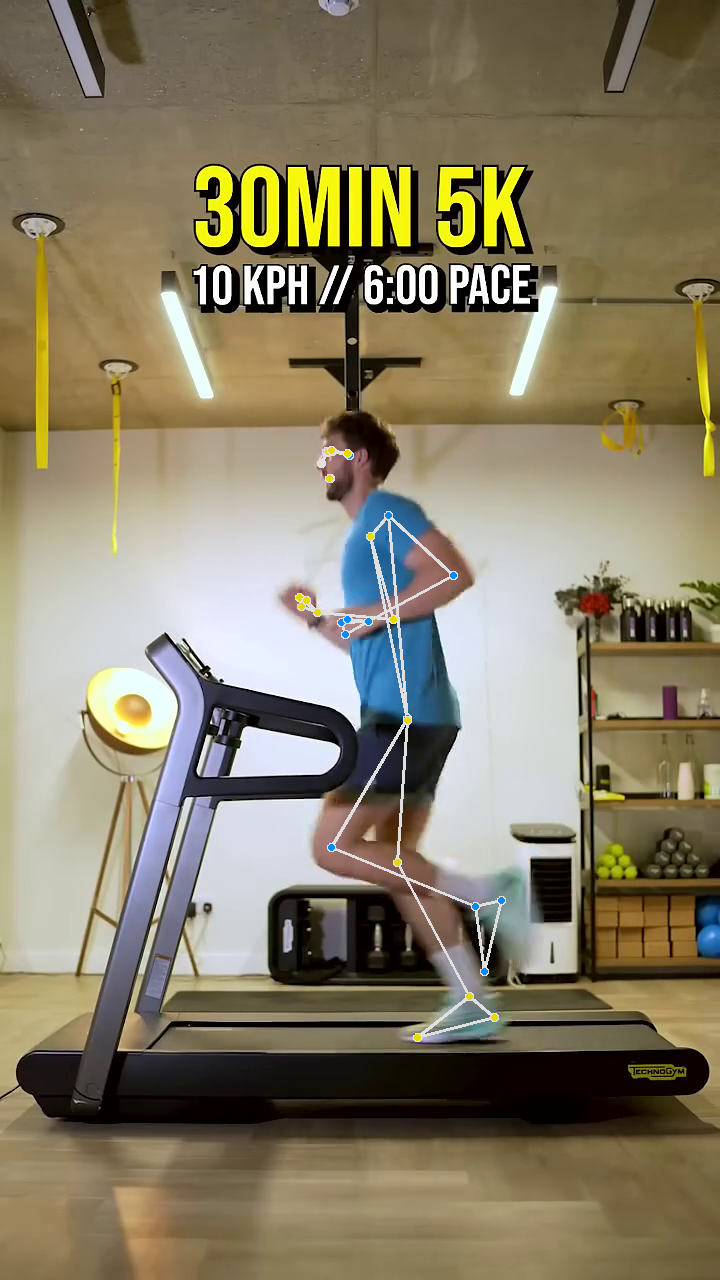

In [8]:
# @title Default title text
import os
from azure.storage.blob import BlobServiceClient, BlobClient
from urllib.parse import urlparse

print(f"Recently uploaded blob url: {blob_url}")
# blob_url = input("Paste blob url: ") #uncomment to take url from user
frame_number = int(input("Choose frame to visualize: "))

from azure.storage.blob import BlobServiceClient

def download_blob_from_url(blob_url):
  """Downloads a blob from Azure Blob Storage given its URL.

  Args:
      blob_url: The URL of the blob to download.
      download_path: The local path where the blob should be saved.
  """
  # create ./downloads directory if not exists
  if not os.path.exists('./downloads'):
    os.makedirs('./downloads')
  blob_name = blob_url.split('/')[-1]
  download_path = os.path.join('./downloads', blob_name)

  # check if blob already exists in download
  if os.path.exists(download_path):
    print(f"Blob already exists at {download_path}")
    return download_path

  try:
    # Parse the blob URL
    parsed_url = urlparse(blob_url)
    account_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    container_name = parsed_url.path.split('/')[1]  # Get container name
    blob_name = parsed_url.path.split('/')[-1]     # Get blob name

    # Create a BlobServiceClient object
    blob_service_client = BlobServiceClient(account_url=account_url, credential=DefaultAzureCredential())

    # Create a BlobClient object
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

    # Download the blob
    with open(download_path, "wb") as download_file:
      download_file.write(blob_client.download_blob().readall())

    print(f"Blob downloaded successfully to {download_path}")
  except Exception as e:
    print(f"An error occurred: {e}")
  return download_path

# download blob (blob_url) to file named as the blob name:

video_file = download_blob_from_url(blob_url)


import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from google.colab.patches import cv2_imshow

# MediaPipe setup (same as before)
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


# extract frame number X from video
def GetFrameFromVideo(video_file, frame_number):
  cap = cv2.VideoCapture(video_file)
  fps = cap.get(cv2.CAP_PROP_FPS)
  print(f"getting frame {frame_number}")
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
  ret, frame = cap.read()
  cap.release()
  return frame

frame = GetFrameFromVideo(video_file, frame_number)

print(frame.shape)
# cv2_imshow(frame)

image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
detection_result = detector.detect(image)

print(detection_result)

keypoints = detection_result.pose_landmarks[0]
landmarks = detection_result.pose_landmarks[0]
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]
# 1280, 720,

# X * shape[1]
# Y * shape[0]
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End

    radians = np.arctan2(c[1]*1280-b[1]*1280, c[0]*720-b[0]*720) - np.arctan2(a[1]*1280-b[1]*1280, a[0]*720-b[0]*720)
    angle = np.abs(radians*180.0/np.pi)

    if angle >180.0:
        angle = 360-angle

    return angle

angle_knee = calculate_angle(hip, knee, ankle)
knee_angle = 180-angle_knee
print(angle_knee)
print(knee_angle)

hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

angle_knee = calculate_angle(hip, knee, ankle)
knee_angle = 180-angle_knee
print(angle_knee)
print(knee_angle)



k23 = keypoints[23]
k25 = keypoints[25]
k27 = keypoints[27]


# print(calculate_angle((k23.x, k23.y), (k25.x, k25.y), (k27.x, k27.y)))

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  # Display the frame


In [9]:
calculateAngle = """let calculate_angle = (x1:real, y1:real, x2:real, y2:real, x3:real, y3:real) {
    let v1x = x2 - x1;
    let v1y = y2 - y1;
    let v2x = x2 - x3;
    let v2y = y2 - y3;
    let dot_product = v1x * v2x + v1y * v2y;
    let magnitude_v1 = sqrt(v1x * v1x + v1y * v1y);
    let magnitude_v2 = sqrt(v2x * v2x + v2y * v2y);
    let cos_theta = dot_product / (magnitude_v1 * magnitude_v2);
    acos(cos_theta) * (180 / 3.141592653589793) // Convert radians to degrees
};"""

# Exessive knee flextion

In [14]:
# Define the query for identifying excessive knee flexion
knee_flexion_query = """
StrideCoordinateTable
| extend LeftKneeAngle = calculate_angle(X23, Y23, X25, Y25, X27, Y27),
         RightKneeAngle = calculate_angle(X24, Y24, X26, Y26, X28, Y28)
| where LeftKneeAngle < 140 or LeftKneeAngle > 180
      or RightKneeAngle < 140 or RightKneeAngle > 180
| extend FixRecommendation = "Ensure knee angles are between 150° and 180°. Focus on maintaining natural knee bend during mid-stance to absorb shock effectively."
| order by frame asc
| project frame, bloburl, LeftKneeAngle, RightKneeAngle;
"""

# Execute the query
response = client.execute(database_name, calculateAngle + knee_flexion_query)

# Print the results
for row in response.primary_results[0]:
    print(f"Frame: {row['frame']}, Blob URL: {row['bloburl']}, Left Knee Angle: {row['LeftKneeAngle']}, Right Knee Angle: {row['RightKneeAngle']}")
    print("----")


Frame: 8, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Knee Angle: 130.52656929590134, Right Knee Angle: 173.66132926681138
----
Frame: 8, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Knee Angle: 130.52656929590134, Right Knee Angle: 173.66132926681138
----
Frame: 28, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Knee Angle: 162.11355294877097, Right Knee Angle: 136.88386358804905
----
Frame: 28, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Knee Angle: 162.1135

# Stride immbalance

In [18]:

# Define the query for identifying stride imbalance
stride_imbalance_query = f"""
let frame_width = {framewidth}; // Set the actual width of the video frame (in pixels)
let imbalance_threshold = 0.1; // 50% of the frame width (for overstriding)
StrideCoordinateTable
| extend LeftAnklePosition = X27, RightAnklePosition = X28 // Left and Right Ankle positions (X-coordinates)
| extend NormalizedLeftAnklePosition = LeftAnklePosition / frame_width, // Normalize X based on frame width
         NormalizedRightAnklePosition = RightAnklePosition / frame_width // Normalize X based on frame width
| extend StrideImbalance = abs(NormalizedLeftAnklePosition - NormalizedRightAnklePosition) // Horizontal difference between left and right ankles
| where StrideImbalance > imbalance_threshold // Check if the difference exceeds the threshold
| extend FixRecommendation = "Work on achieving more balanced stride by strengthening the weaker leg and focusing on symmetrical movements of both legs during the stride."
| project frame, bloburl, StrideImbalance;
"""

response = client.execute(database_name, stride_imbalance_query)

# Print the results with explanation
for row in response.primary_results[0]:
    print(f"Frame: {row['frame']}, Blob URL: {row['bloburl']}, Stride Imbalance: {row['StrideImbalance']}")
    print("----")

    # Explanation
    print("Explanation:")
    print("Asymmetry in stride indicates inefficiency in force transfer and increased risk of injury. When the left and right legs are not moving "
          "symmetrically (i.e., the horizontal distance between the ankles differs significantly), it suggests muscle imbalances or compensations. "
          "Achieving a balanced stride requires strengthening the weaker leg and improving coordination between both legs.")


Frame: 0, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Stride Imbalance: 0.2880120873451233
----
Explanation:
Asymmetry in stride indicates inefficiency in force transfer and increased risk of injury. When the left and right legs are not moving symmetrically (i.e., the horizontal distance between the ankles differs significantly), it suggests muscle imbalances or compensations. Achieving a balanced stride requires strengthening the weaker leg and improving coordination between both legs.
Frame: 4, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Stride Imbalance: 0.26635053753852844
----
Explanation:
Asymmetry in stride indicates inefficiency in force transfer and increased risk of injury. When the left and right legs are not moving sym

# Execssive hip flexion

In [19]:
# Define the query for identifying excessive hip flexion
hip_flexion_query = """
StrideCoordinateTable
| extend LeftHipAngle = calculate_angle(X23, Y23, X25, Y25, X27, Y27),
         RightHipAngle = calculate_angle(X24, Y24, X26, Y26, X28, Y28)
| where LeftHipAngle < 40 or LeftHipAngle > 60
      or RightHipAngle < 40 or RightHipAngle > 60
| extend FixRecommendation = "Maintain a neutral pelvic position with slight hip flexion (40° to 60°). Focus on core strengthening exercises to support better hip alignment."
| project frame, bloburl, LeftHipAngle, RightHipAngle;
"""

# Execute the query
response = client.execute(database_name, calculateAngle + hip_flexion_query)

# Print the results with explanation
for row in response.primary_results[0]:
    print(f"Frame: {row['frame']}, Blob URL: {row['bloburl']}, Left Hip Angle: {row['LeftHipAngle']}, Right Hip Angle: {row['RightHipAngle']}")
    print("----")

    # Explanation
    print("Explanation:")
    print("Excessive flexion or extension of the hips (angles less than 40° or greater than 60°) leads to inefficient motion, poor energy transfer, "
          "and increased strain on the lower back and hip flexors. In ideal running form, the pelvis should be aligned with a slight flexion angle, "
          "ensuring smooth, efficient movement and preventing overuse injuries.")


Frame: 0, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Hip Angle: 168.12613223242624, Right Hip Angle: 162.52577208752237
Fix Recommendation: Maintain a neutral pelvic position with slight hip flexion (40° to 60°). Focus on core strengthening exercises to support better hip alignment.
----
Explanation:
Excessive flexion or extension of the hips (angles less than 40° or greater than 60°) leads to inefficient motion, poor energy transfer, and increased strain on the lower back and hip flexors. In ideal running form, the pelvis should be aligned with a slight flexion angle, ensuring smooth, efficient movement and preventing overuse injuries.
Frame: 4, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Hip Angle: 154.4799690443306, 

# Foot strike efficiency query

In [21]:
# Define the query for identifying foot strike efficiency

# Please take into account that the recommended distance to the camera should be around 5 meters so it will detect better, you can adjust this number for each video, according to the distance of the runner

foot_strike_efficiency_query = f"""let frame_width = {framewidth}; // Set the actual width of the video frame (in pixels)
let overstriding_threshold = frame_width * 0.5; // 50% of the frame width (for overstriding)
StrideCoordinateTable
| extend LeftFootPosition = X29, RightFootPosition = X30 // Left and Right Foot Index
| where LeftFootPosition > overstriding_threshold or RightFootPosition > overstriding_threshold
| extend FixRecommendation = "Focus on landing with the midfoot, avoid overstriding, and aim for a quick cadence with foot placement directly beneath the body."
| project frame, bloburl, LeftFootPosition, RightFootPosition, FixRecommendation;
"""

# Why 0.5?
# This threshold represents a general guideline for detecting overstriding. Overstriding occurs when the foot is too far ahead of the body’s center of mass, creating a braking effect.
# A threshold of 0.5 for the X-coordinate of the foot index indicates that the foot is placed too far ahead, which can slow the runner down and cause inefficient force absorption.

# Execute the query
response = client.execute(database_name, foot_strike_efficiency_query)

# Print the results with explanation
for row in response.primary_results[0]:
    print(f"Frame: {row['frame']}, Blob URL: {row['bloburl']}, Left Foot Position: {row['LeftFootPosition']}, Right Foot Position: {row['RightFootPosition']}")
    print(f"Fix Recommendation: {row['FixRecommendation']}")
    print("----")

    # Explanation
    print("Explanation:")
    print("Overstriding or landing heavily on the heels causes unnecessary braking forces, making it harder to maintain forward momentum. "
          "Proper foot strike mechanics involve landing with the **midfoot**, avoiding **overstriding**, and ensuring the foot lands directly beneath "
          "the body to maintain smooth and efficient running mechanics.")


Frame: 0, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Foot Position: 536.3135719299316, Right Foot Position: 327.5328469276428
Fix Recommendation: Focus on landing with the midfoot, avoid overstriding, and aim for a quick cadence with foot placement directly beneath the body.
----
Explanation:
Overstriding or landing heavily on the heels causes unnecessary braking forces, making it harder to maintain forward momentum. Proper foot strike mechanics involve landing with the **midfoot**, avoiding **overstriding**, and ensuring the foot lands directly beneath the body to maintain smooth and efficient running mechanics.
Frame: 4, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Foot Position: 546.473822593689, Right Foot Position: 

# Arm swing analysis query

In [22]:
# Define the query for analyzing arm swing
arm_swing_analysis_query = """
StrideCoordinateTable
| extend LeftArmAngle = calculate_angle(X11, Y11, X13, Y13, X15, Y15), // Shoulder-Elbow-Wrist
         RightArmAngle = calculate_angle(X12, Y12, X14, Y14, X16, Y16)
| where LeftArmAngle > 180 or RightArmAngle > 180 // Excessive arm swing (could be a symptom of poor posture)
         or LeftArmAngle < 50 or RightArmAngle < 50 // Lack of arm swing (could indicate poor coordination)
| extend FixRecommendation = "Maintain a moderate and natural arm swing that matches the legs to help maintain balance and rhythm."
| project frame, bloburl, LeftArmAngle, RightArmAngle, FixRecommendation;
"""

# Execute the query
response = client.execute(database_name, calculateAngle + arm_swing_analysis_query)

# Print the results with explanation
for row in response.primary_results[0]:
    print(f"Frame: {row['frame']}, Blob URL: {row['bloburl']}, Left Arm Angle: {row['LeftArmAngle']}, Right Arm Angle: {row['RightArmAngle']}")
    print(f"Fix Recommendation: {row['FixRecommendation']}")
    print("----")

    # Explanation
    print("Explanation:")
    print("Excessive or underactive arm swing disturbs the body's rhythm and balance. A proper arm swing helps maintain forward momentum, "
          "supports the leg stride, and conserves energy. Ensure arms swing naturally from the shoulders, not too widely or too tightly.")


Frame: 8, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Arm Angle: 45.373414163641215, Right Arm Angle: 61.28712223922379
Fix Recommendation: Maintain a moderate and natural arm swing that matches the legs to help maintain balance and rhythm.
----
Explanation:
Excessive or underactive arm swing disturbs the body's rhythm and balance. A proper arm swing helps maintain forward momentum, supports the leg stride, and conserves energy. Ensure arms swing naturally from the shoulders, not too widely or too tightly.
Frame: 16, Blob URL: https://eddiebkheethackathonsa.blob.core.windows.net/convertedvideos/ybb_y2meta_net_720p-how-5k-running-paces-looks-on-a-treadmill-15-minutes-5k__1__converted_mp4, Left Arm Angle: 48.75874488762548, Right Arm Angle: 67.69724356708275
Fix Recommendation: Maintain a moderate and natural arm swing that matches the legs to help mainta